In [17]:
import networkx as nx
import numpy as np
from simulation import Simulation
import matplotlib.pyplot as plt
import random

In [18]:
def gen_exp_graph(N, gamma):
    """
    Returns a networx graph according to a power law degree distribution
    """
    sum_is_odd = True

    while sum_is_odd:
        sequence = np.random.poisson(gamma, N)
        sum_is_odd = sum(sequence) % 2 == 1

    return nx.configuration_model(sequence)



In [19]:
graphs = []
n_graphs = 100
N = 100
for i in range(n_graphs):
    gamma = 2.0 + 0.5 / n_graphs * i
    
    G = gen_exp_graph(N, gamma)
    graphs.append(G)

In [29]:
def compute_B(G, D_I, beta, mu, n_walkers):
    largest_cc = max(nx.connected_components(G), key=len)
    F = G.subgraph(largest_cc).copy()

    N_tilde = F.number_of_nodes()
    B = np.zeros((N_tilde,N_tilde))
    A = nx.to_numpy_array(F)
    degs = np.array([d for v, d in F.degree()])

    avg_deg = np.average(degs)
    for i in range(N_tilde):
        for j in range(N_tilde):
            eq = int(i == j)
            B[i,j] += eq * ((beta * n_walkers) / (avg_deg * N_tilde) * degs[i] - mu - D_I)
            B[i,j] += (1- eq) * D_I * A[j,i] / degs[j]
    return B

In [30]:
D_S = 1.0
D_I = 0.1
beta = 1 / 1000
mu = 1 / 10
n_walkers = 5000

min_eig = np.inf
max_eig = -np.inf

G_1 = None
G_2 = None

for i in range(n_graphs):
    B = compute_B(graphs[i], D_I, beta, mu, n_walkers)
    eig, _ = np.linalg.eig(B)
    c = np.max(eig)

    if c < min_eig:
        min_eig = c
        G_1 = graphs[i]

    if c > max_eig:
        max_eig = c
        G_2 = graphs[i]

print("Min eig: ", min_eig)
print("Max eig: ", max_eig)


Min eig:  -0.02234950628391726
Max eig:  0.07395208560006847


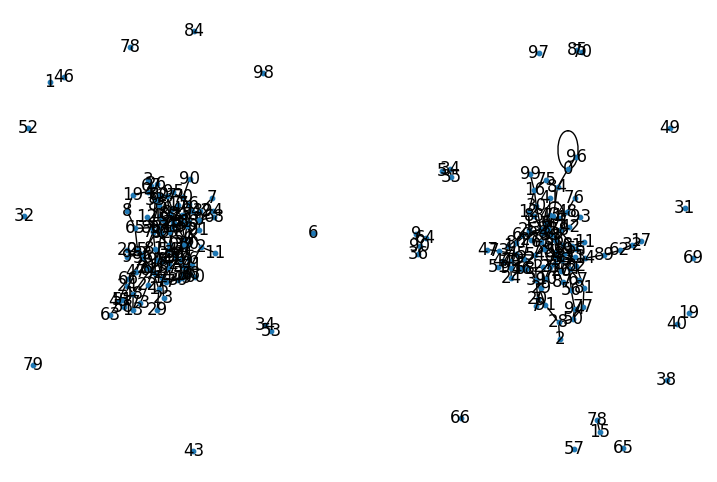

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))

nx.draw(G_1, node_size = 10, with_labels = True, ax = ax1)
nx.draw(G_2, node_size = 10, with_labels = True, ax = ax2)

In [23]:
sim_1 = Simulation(G_1, D_S, D_I, beta, mu)\
    .init_walkers_uniform(n_walkers=n_walkers)\
    .infect_walkers(0.01)\
    .run(1, 0.01)

sim_2 = Simulation(G_2, D_S, D_I, beta, mu)\
    .init_walkers_uniform(n_walkers=n_walkers)\
    .infect_walkers(0.01)\
    .run(1, 0.01)

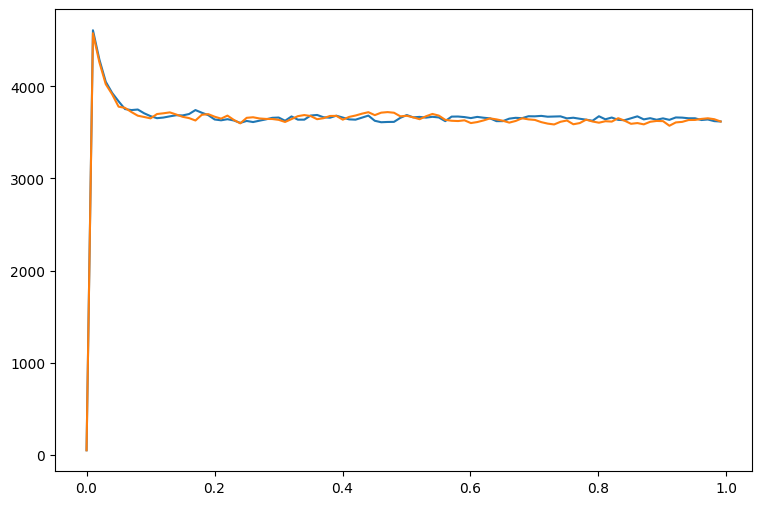

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

ax.plot(sim_1.timeline, np.sum(sim_1.infected_log, axis=1), label='infected')
ax.plot(sim_2.timeline, np.sum(sim_2.infected_log, axis=1), label='infected')
